# Sched DVFS

This notebook is used for hikey960 board for sched DVFS demo example.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

# Uncomment the follwing line to enabled devlib debugging statements
#logging.getLogger().setLevel(logging.DEBUG)

2017-07-14 15:55:21,380 INFO    : root         : Using LISA logging configuration:
2017-07-14 15:55:21,384 INFO    : root         :   /data/lisa_remote/lisa/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


2017-07-14 15:55:23,976 WARNING : EnergyModel  : Unusual max capacity (1023), overriding capacity_scale


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'hikey960',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    #"host"        : '192.168.0.1',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
       "0": 301, "1": 301, "2": 301, "3": 301, "4": 226, "5": 226, "6": 226, "7": 226
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_load_avg_cpu",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    },
    
     # Where results are collected
    "results_dir" : "Sched_DVFS_hikey960",

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2017-07-14 15:55:27,923 INFO    : TestEnv      : Using base path: /data/lisa_remote/lisa
2017-07-14 15:55:27,929 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-07-14 15:55:27,931 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-07-14 15:55:27,937 INFO    : TestEnv      : External tools using:
2017-07-14 15:55:27,938 INFO    : TestEnv      :    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
2017-07-14 15:55:27,940 INFO    : TestEnv      :    CATAPULT_HOME: /data/lisa_remote/lisa/tools/catapult
2017-07-14 15:55:27,941 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'hwmon']
2017-07-14 15:55:27,948 INFO    : TestEnv      : Connecting Android target [DEFAULT]
2017-07-14 15:55:27,950 INFO    : TestEnv      : Connection settings:
2017-07-14 15:55:27,951 INFO    : TestEnv      :    None
2017-07-14 15:55:28,952 INFO    : TestEnv      : Initializing target workdir:
2017-07-14 15:55:28,954 INFO    : TestEnv    

In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

2017-07-14 15:55:32,715 INFO    : root         : Target ABI: arm64, CPus: ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']


# Support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [6]:
target.cpufreq.get_all_governors()

{'0': 'interactive',
 '1': 'interactive',
 '2': 'interactive',
 '3': 'interactive',
 '4': 'interactive',
 '5': 'interactive',
 '6': 'interactive',
 '7': 'interactive'}

In [7]:
target.cpufreq.get_all_frequencies()

{'0': '999000',
 '1': '999000',
 '2': '999000',
 '3': '999000',
 '4': '903000',
 '5': '903000',
 '6': '903000',
 '7': '903000'}

In [8]:
target.cpufreq.list_governors(0)

['interactive', 'ondemand', 'userspace', 'performance', 'sched']

In [9]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_userspace():
    target.cpufreq.set_all_governors('userspace')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [10]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    'userspace' : {
        'label' : 'pws',
        'set' :  set_userspace,
    },
     'interactive' : {
         'label' : 'int',
         'set' :  set_interactive,
     },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
    'ondemand' : {
        'label' : 'odm',
        'set' :  set_ondemand,
    }
}

# The set of results forlder for each comparition test
results = {}

In [31]:
#
# if hikey960 has AEP or ACME, set below variable as 1
#
hikey960_has_energy_meter = 0

def experiment(governor, rtapp, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    # Start FTrace and Energy monitoring
    te.ftrace.start()
    
    if hikey960_has_energy_meter:
        te.emeter.reset()
    
    # Run the workload
    rtapp.run(out_dir=exp_dir)
    
    # Stop FTrace and sample Energy consumption
    if hikey960_has_energy_meter:
        nrg = te.emeter.report(exp_dir).channels
    else:
        nrg = "0.0"
    
    te.ftrace.stop()
    
    logging.info('Energy: %s', nrg)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(te.platform, exp_dir,
               events=my_tests_conf['ftrace']['events'])
    
    # return all the experiment data
    return {
        'dir'      : exp_dir,
        'energy'   : copy.deepcopy(nrg),
        'trace'    : trace_file,
        'tr'       : tr,
        'ftrace'   : tr.ftrace
    }

    
def compare(tid, rtapp):    
    logging.info('Test case: %s', tid)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        test_dir = os.path.join(res_dir, governor)
        results[tid][governor] = experiment(governor, rtapp, test_dir)
        
def plot(tid):
    global results
    
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
        
    for governor in confs:
        pa = PerfAnalysis(results[tid][governor]['dir'])
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
        
def report_nrg(tid):
    global results
    
    print "{:15s} | {:>9s} {:>9s} {:>9s}"\
        .format('Governor', 'A53', 'A57', 'Total')
    print "{:-<16s}+{:-<30s}".format('', '')
    for governor in confs:
        plot_title = "{}".format(governor.upper())
        nrg = results[tid][governor]['energy']
        nrg_little = float(nrg['little'])
        nrg_big = float(nrg['big'])
        nrg_sum = nrg_little + nrg_big
        print "{:15s} | {:9.3f} {:9.3f} {:9.3f}"\
            .format(governor, nrg_little, nrg_big, nrg_sum)

In [12]:

te.emeter.reset()

AttributeError: 'NoneType' object has no attribute 'reset'

# Test: light/heavy/light

In [32]:
# Define a label for this test case
test_case = 'light-heavy-light'

light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=str(target.bl.bigs_online[0]))
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100)
light2 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10)

lhl_task = light1 + heavy1 + light2

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhl_task.get()
    },
    run_dir=target.working_directory
);

2017-07-14 15:47:22,415 INFO    : Workload     : Setup new workload smoke
2017-07-14 15:47:22,500 INFO    : Workload     : Workload duration defined by longest task
2017-07-14 15:47:22,503 INFO    : Workload     : Default policy: SCHED_OTHER
2017-07-14 15:47:22,507 INFO    : Workload     : ------------------------
2017-07-14 15:47:22,510 INFO    : Workload     : task [task1], sched: using default policy
2017-07-14 15:47:22,512 INFO    : Workload     :  | calibration CPU: 4
2017-07-14 15:47:22,516 INFO    : Workload     :  | loops count: 1
2017-07-14 15:47:22,518 INFO    : Workload     :  | CPUs affinity: 4
2017-07-14 15:47:22,521 INFO    : Workload     : + phase_000001: duration 1.000000 [s] (100 loops)
2017-07-14 15:47:22,522 INFO    : Workload     : |  period    10000 [us], duty_cycle  10 %
2017-07-14 15:47:22,529 INFO    : Workload     : |  run_time   1000 [us], sleep_time   9000 [us]
2017-07-14 15:47:22,542 INFO    : Workload     : + phase_000002: duration 0.100000 [s] (1 loops)
20

In [33]:
# Run this workload in all the configurations
compare(test_case, rtapp)

2017-07-14 15:47:24,315 INFO    : root         : Test case: light-heavy-light
2017-07-14 15:47:24,325 INFO    : root         :   results folder: /data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light
2017-07-14 15:47:24,342 INFO    : root         : ------------------------
2017-07-14 15:47:24,344 INFO    : root         : Run workload using performance governor
2017-07-14 15:47:27,307 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:47:27,425 DEBUG   : FtraceCollector : Trace CPUIdle states
2017-07-14 15:47:27,536 INFO    : Workload     : Workload execution START:
2017-07-14 15:47:27,543 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1


2017-07-14 15:47:29,911 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:47:30,156 INFO    : root         : Energy: 0.0
2017-07-14 15:47:32,074 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light/performance]...
2017-07-14 15:47:32,076 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:47:32,081 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:47:32,849 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:47:32,857 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 15:47:32,860 DEBUG   : Trace        :  - cpu_frequency_devlib
2017-07-14 15:47:32,866 DEBUG   : Trace        :  - sched_switch
2017-07-14 15:47:32,885 INFO    : Trace        : Plat

2017-07-14 15:47:39,263 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:47:39,555 INFO    : root         : Energy: 0.0
2017-07-14 15:47:41,474 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light/userspace]...
2017-07-14 15:47:41,477 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:47:41,481 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:47:43,595 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:47:43,601 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 15:47:43,609 DEBUG   : Trace        :  - cpu_frequency_devlib
2017-07-14 15:47:43,611 DEBUG   : Trace        :  - sched_switch
2017-07-14 15:47:43,623 INFO   

2017-07-14 15:47:53,737 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:47:53,968 INFO    : root         : Energy: 0.0
2017-07-14 15:47:55,875 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light/ondemand]...
2017-07-14 15:47:55,880 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:47:55,884 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:47:56,763 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:47:56,769 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 15:47:56,776 DEBUG   : Trace        :  - cpu_capacity
2017-07-14 15:47:56,778 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 15:4

2017-07-14 15:48:04,825 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:48:05,157 INFO    : root         : Energy: 0.0
2017-07-14 15:48:07,152 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light/sched]...
2017-07-14 15:48:07,161 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:48:07,167 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:48:09,206 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:48:09,221 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 15:48:09,226 DEBUG   : Trace        :  - cpu_capacity
2017-07-14 15:48:09,233 DEBUG   : Trace        :  - sched_load_av

2017-07-14 15:48:16,995 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:48:17,281 INFO    : root         : Energy: 0.0
2017-07-14 15:48:19,249 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-light/interactive]...
2017-07-14 15:48:19,257 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:48:19,270 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:48:21,306 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:48:21,330 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 15:48:21,339 DEBUG   : Trace        :  - cpu_capacity
2017-07-14 15:48:21,349 DEBUG   : T

In [34]:
# Plot all data collected from experiments
def plot(tid):
    global results
    
    # Plot CPU LoadAvg and Capacity (for CPU0)
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        signals=[
                            "sched_load_avg_cpu:util_avg",
                            "cpu_capacity:capacity"],
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        trace = results[tid][governor]['tr']
        logging.info("%s:", plot_title)
        trace.analysis.frequency.plotClusterFrequencies(title=plot_title)
    
    # Plot RTApp performance index
    for governor in confs:
        plot_title = "RTApp performances, {}".format(governor.upper())
        pa = PerfAnalysis(results[tid][governor]['dir'])
        logging.info("%s:", plot_title)
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
            

2017-07-14 15:48:25,501 INFO    : root         : Cluster frequencies, PERFORMANCE:
2017-07-14 15:48:26,416 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:48:26,523 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:48:27,696 INFO    : Analysis     : LITTLE cluster average frequency: 0.999 GHz
2017-07-14 15:48:27,699 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-07-14 15:48:27,701 INFO    : root         : Cluster frequencies, USERSPACE:
2017-07-14 15:48:28,359 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:48:28,480 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:48:29,934 INFO    : Analysis     : LITTLE cluster average frequency: 0.999 GHz
2017-07-14 15:48:29,946 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-07-14 15:48:29,954 INFO    : root         : Cluster

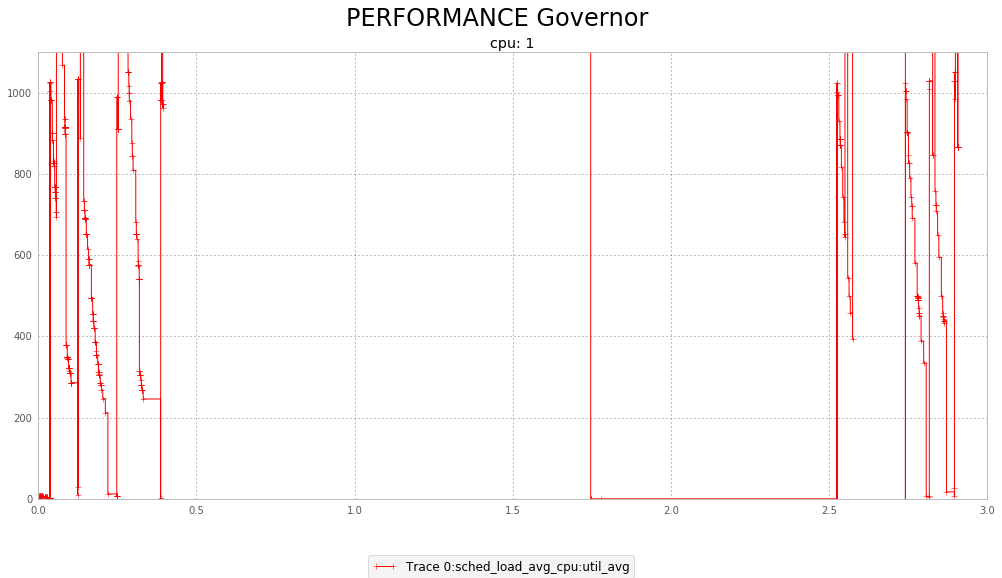

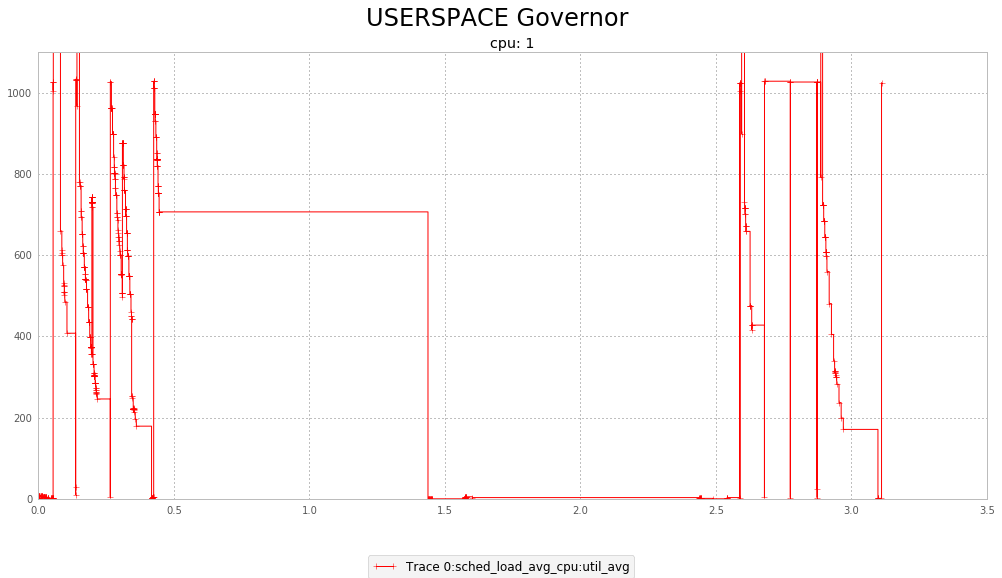

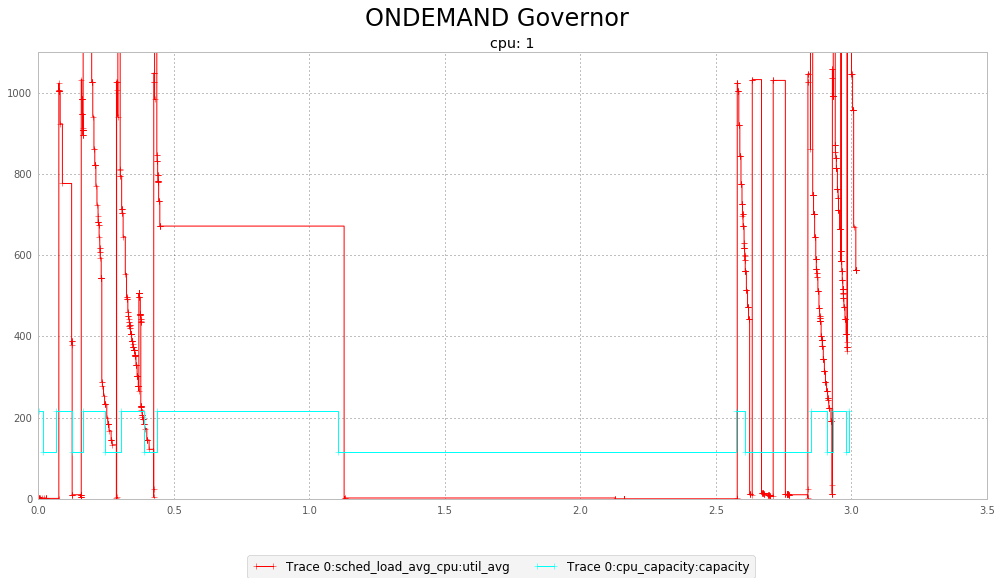

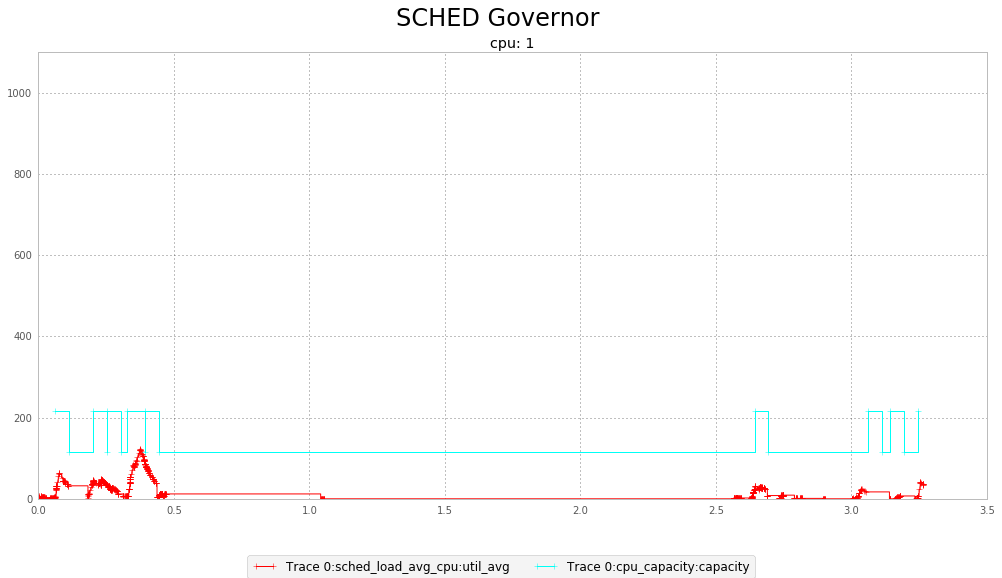

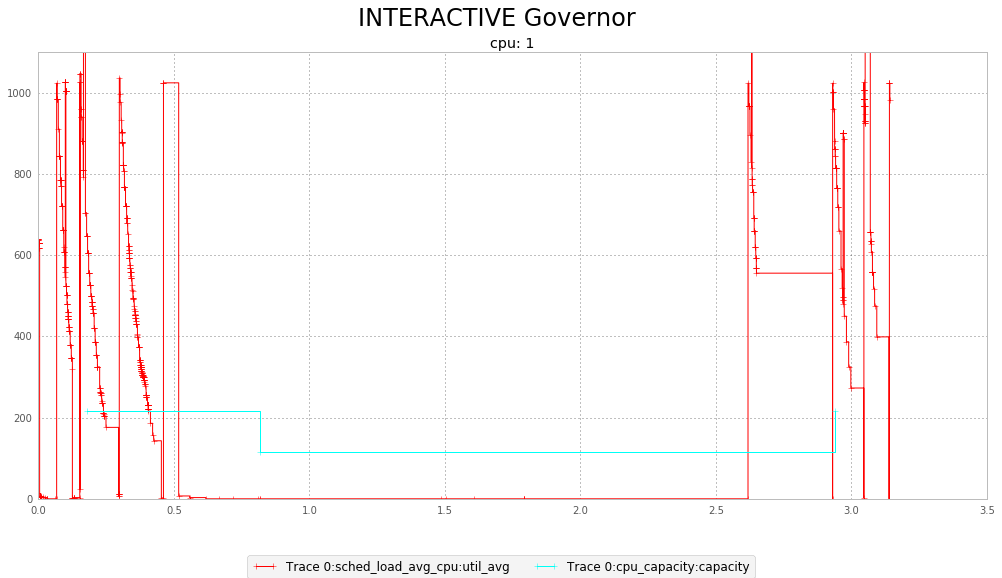

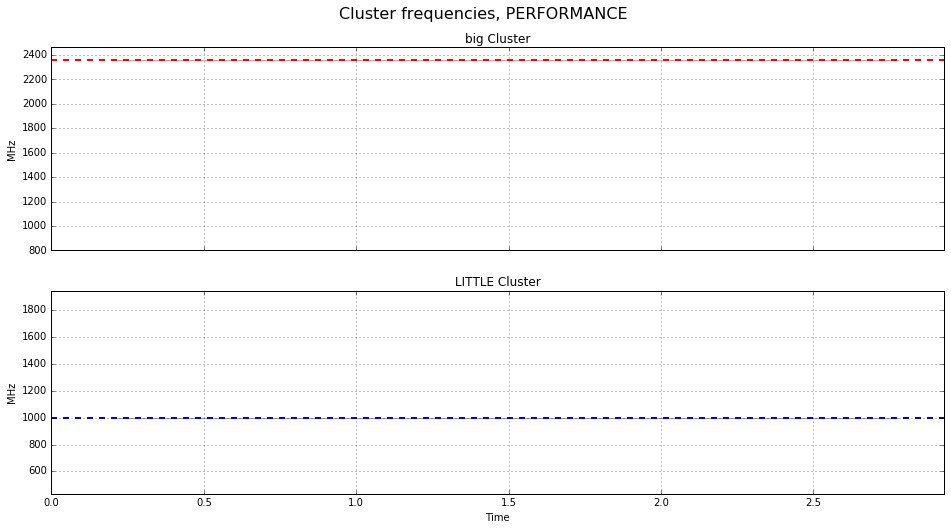

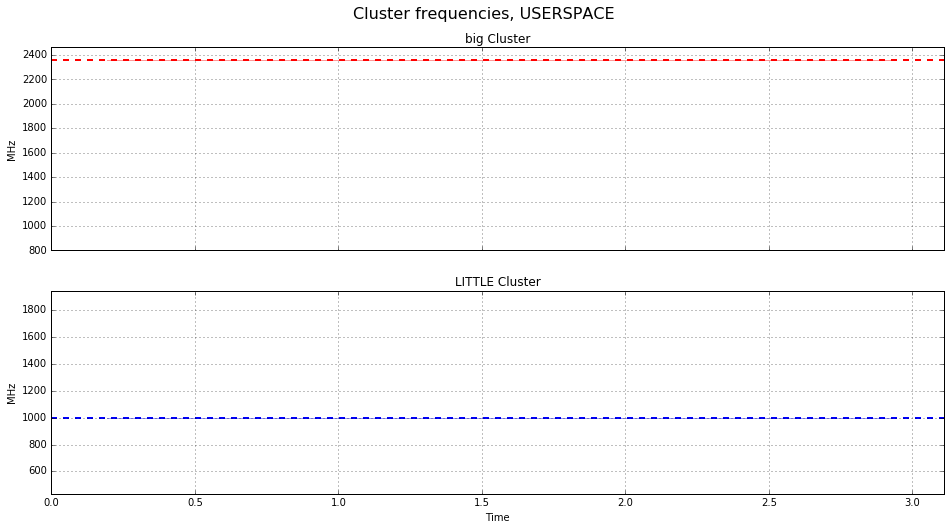

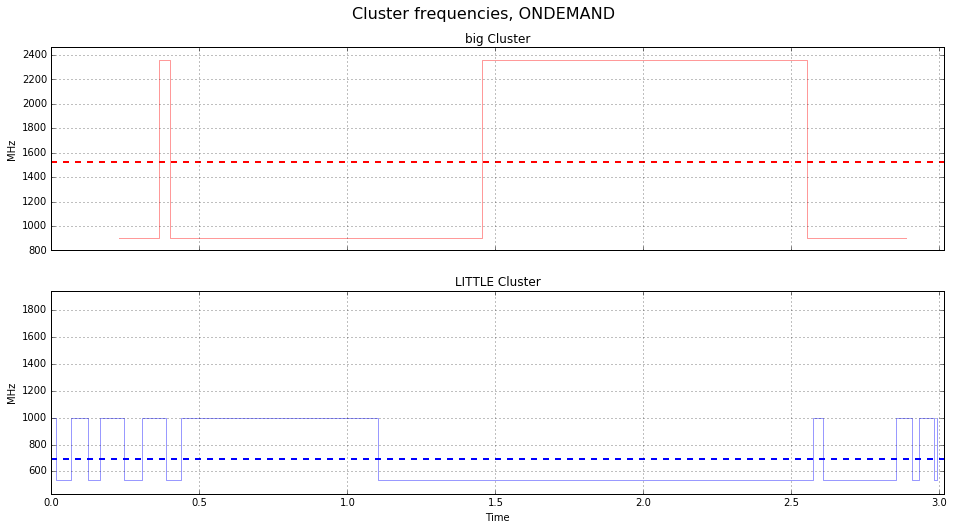

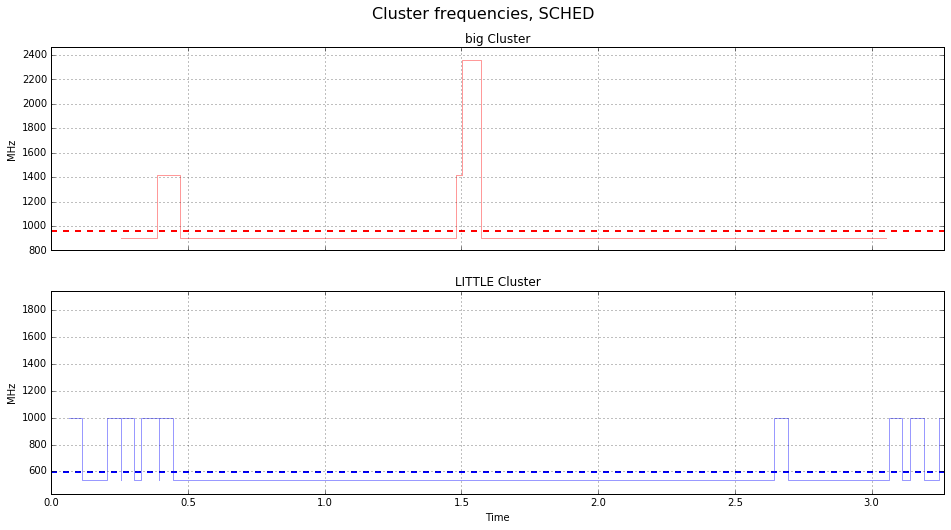

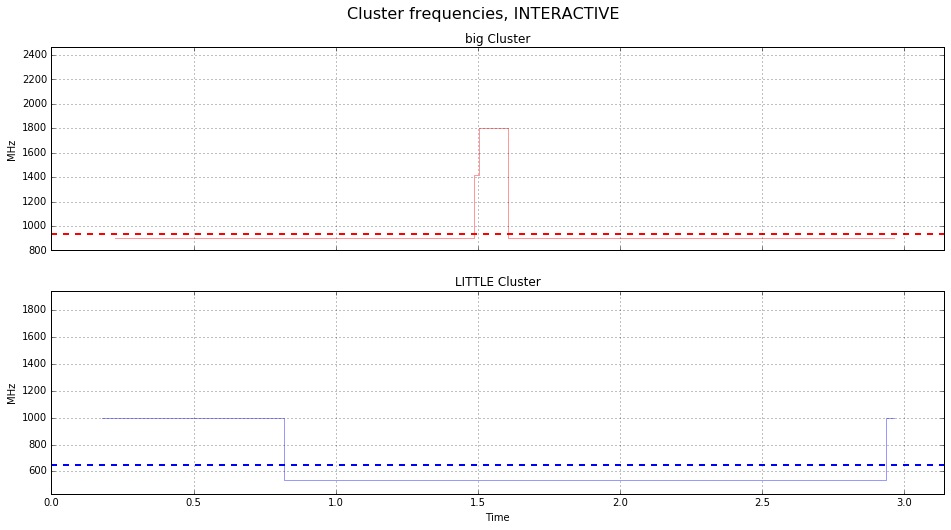

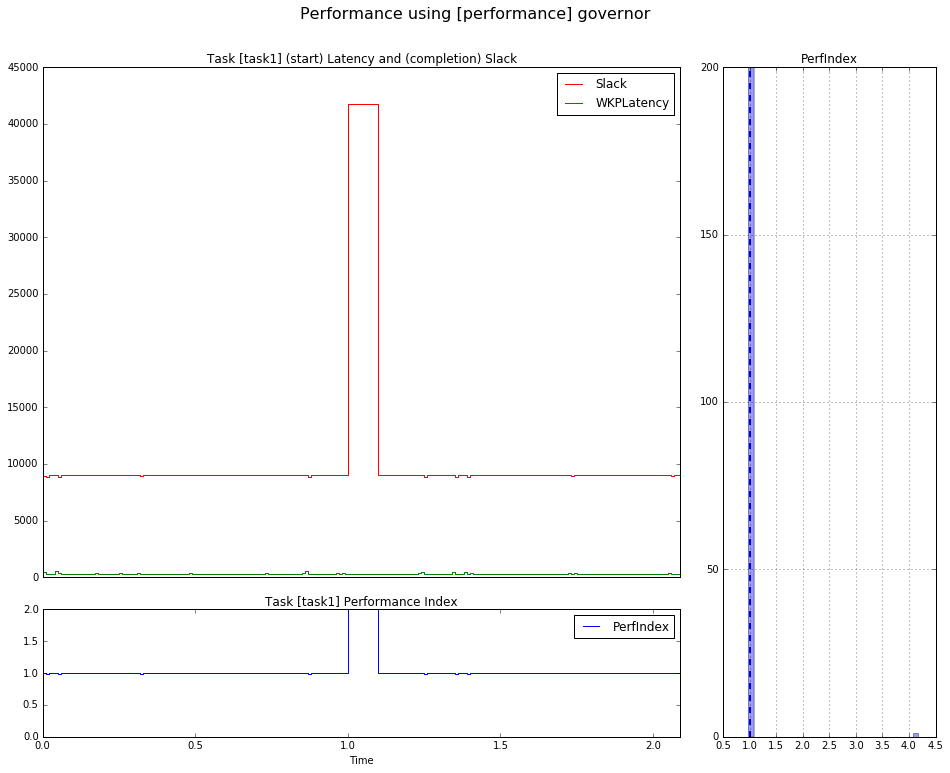

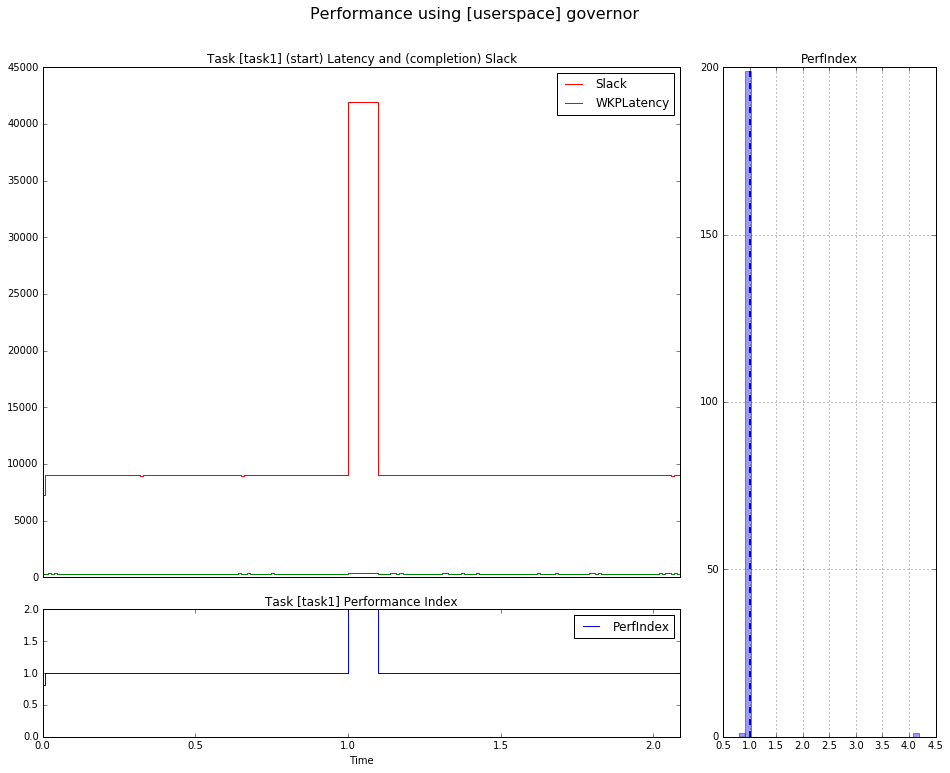

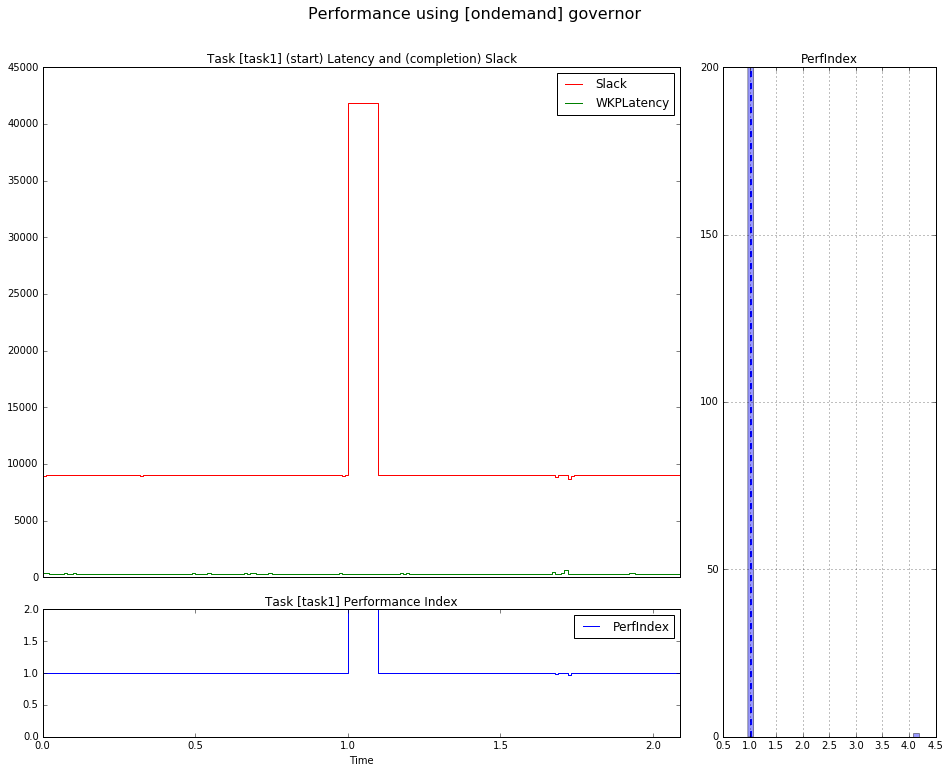

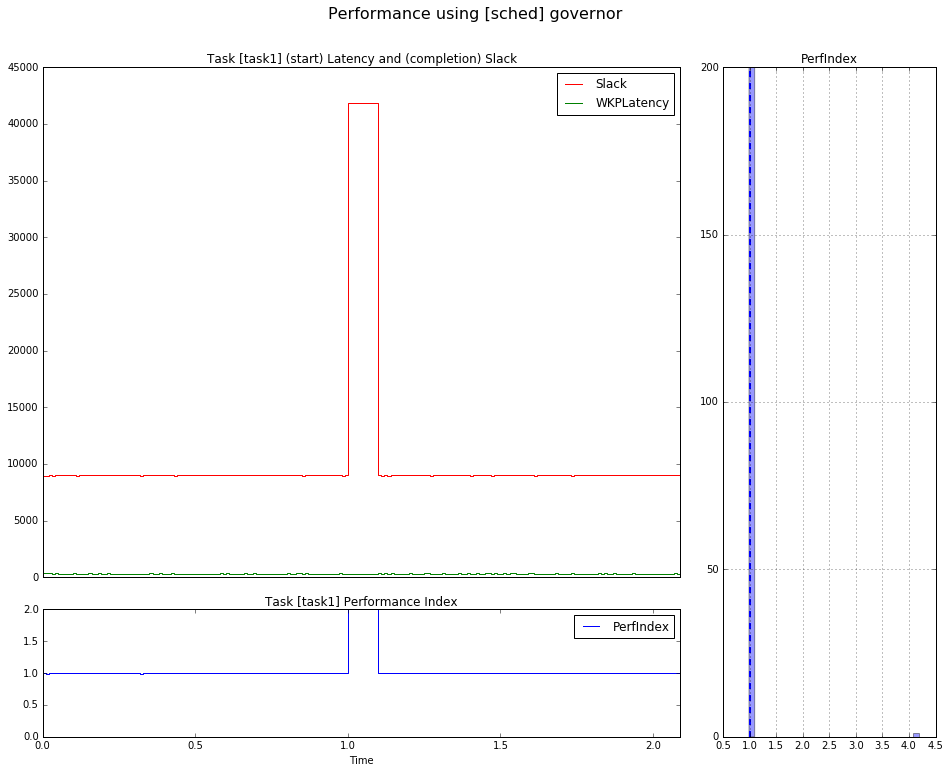

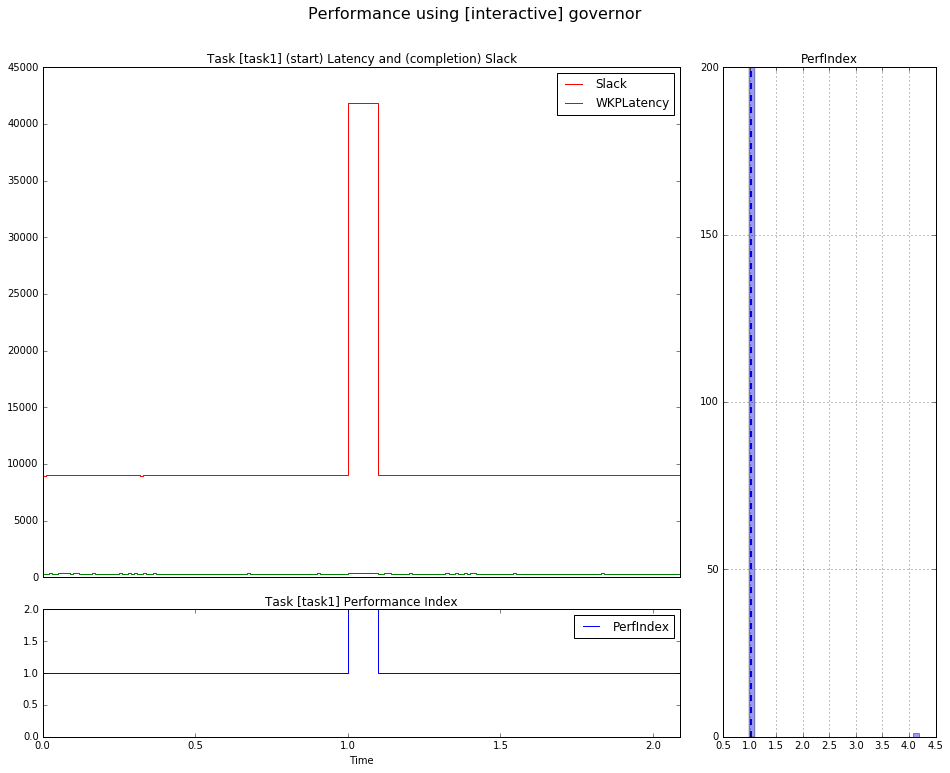

In [35]:
plot(test_case)

In [37]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------


TypeError: string indices must be integers, not str

# Test: light/heavy/medium

In [38]:
# Define a label for this test case
test_case = 'light-heavy-medium'

light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=str(target.bl.bigs_online[0]))
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100)
mdium1 = Periodic(duty_cycle_pct=50, duration_s=1.0, period_ms= 10)

lhm_task = light1 + heavy1 + mdium1

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhm_task.get()
    },
    run_dir=target.working_directory
);



2017-07-14 15:50:32,317 INFO    : Workload     : Setup new workload smoke
2017-07-14 15:50:32,441 INFO    : Workload     : Workload duration defined by longest task
2017-07-14 15:50:32,448 INFO    : Workload     : Default policy: SCHED_OTHER
2017-07-14 15:50:32,454 INFO    : Workload     : ------------------------
2017-07-14 15:50:32,464 INFO    : Workload     : task [task1], sched: using default policy
2017-07-14 15:50:32,469 INFO    : Workload     :  | calibration CPU: 4
2017-07-14 15:50:32,477 INFO    : Workload     :  | loops count: 1
2017-07-14 15:50:32,479 INFO    : Workload     :  | CPUs affinity: 4
2017-07-14 15:50:32,492 INFO    : Workload     : + phase_000001: duration 1.000000 [s] (100 loops)
2017-07-14 15:50:32,494 INFO    : Workload     : |  period    10000 [us], duty_cycle  10 %
2017-07-14 15:50:32,499 INFO    : Workload     : |  run_time   1000 [us], sleep_time   9000 [us]
2017-07-14 15:50:32,502 INFO    : Workload     : + phase_000002: duration 0.100000 [s] (1 loops)
20

In [39]:
# Run this workload in all the configurations
compare(test_case, rtapp)

2017-07-14 15:50:50,639 INFO    : root         : Test case: light-heavy-medium
2017-07-14 15:50:50,655 INFO    : root         :   results folder: /data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium
2017-07-14 15:50:50,689 INFO    : root         : ------------------------
2017-07-14 15:50:50,701 INFO    : root         : Run workload using performance governor
2017-07-14 15:50:53,388 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:50:53,517 DEBUG   : FtraceCollector : Trace CPUIdle states
2017-07-14 15:50:53,673 INFO    : Workload     : Workload execution START:
2017-07-14 15:50:53,677 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1


2017-07-14 15:50:56,205 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:50:56,482 INFO    : root         : Energy: 0.0
2017-07-14 15:50:58,470 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium/performance]...
2017-07-14 15:50:58,472 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:50:58,482 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:51:00,480 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:51:00,490 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 15:51:00,495 DEBUG   : Trace        :  - cpu_frequency_devl

2017-07-14 15:51:07,739 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:51:08,028 INFO    : root         : Energy: 0.0
2017-07-14 15:51:10,276 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium/userspace]...
2017-07-14 15:51:10,284 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:51:10,286 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:51:11,002 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:51:11,009 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 15:51:11,011 DEBUG   : Trace        :

2017-07-14 15:51:21,553 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:51:21,805 INFO    : root         : Energy: 0.0
2017-07-14 15:51:23,592 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium/ondemand]...
2017-07-14 15:51:23,601 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:51:23,604 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:51:24,672 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:51:24,679 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 15:51:24,684 DEBUG 

2017-07-14 15:51:32,239 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:51:32,550 INFO    : root         : Energy: 0.0
2017-07-14 15:51:34,536 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium/sched]...
2017-07-14 15:51:34,541 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:51:34,548 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:51:36,254 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:51:36,261 DEBUG   : Trace        :  - cpu_frequency
2017-07-1

2017-07-14 15:51:43,911 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 15:51:44,182 INFO    : root         : Energy: 0.0
2017-07-14 15:51:46,064 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/Sched_DVFS_hikey960/light-heavy-medium/interactive]...
2017-07-14 15:51:46,072 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-07-14 15:51:46,074 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 15:51:46,826 DEBUG   : Trace        : Events found on trace:
2017-07-14 15:51:46,833 DEBUG   : Trace      

2017-07-14 15:51:49,402 INFO    : root         : Cluster frequencies, PERFORMANCE:
2017-07-14 15:51:49,910 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:51:49,968 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:51:50,702 INFO    : Analysis     : LITTLE cluster average frequency: 0.999 GHz
2017-07-14 15:51:50,710 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-07-14 15:51:50,712 INFO    : root         : Cluster frequencies, USERSPACE:
2017-07-14 15:51:51,072 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:51:51,155 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-07-14 15:51:51,856 INFO    : Analysis     : LITTLE cluster average frequency: 0.999 GHz
2017-07-14 15:51:51,862 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-07-14 15:51:51,864 INFO    : root         : Cluster

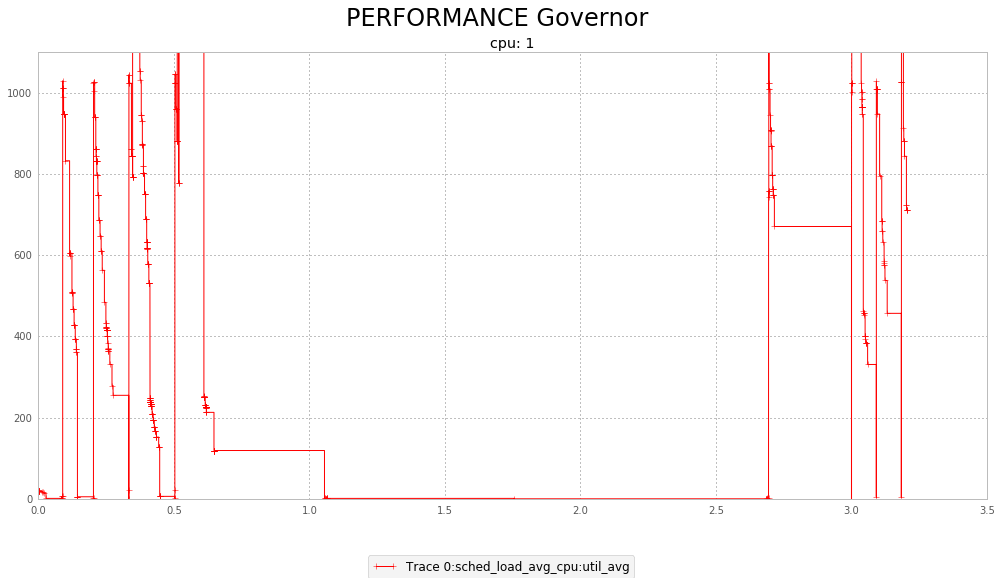

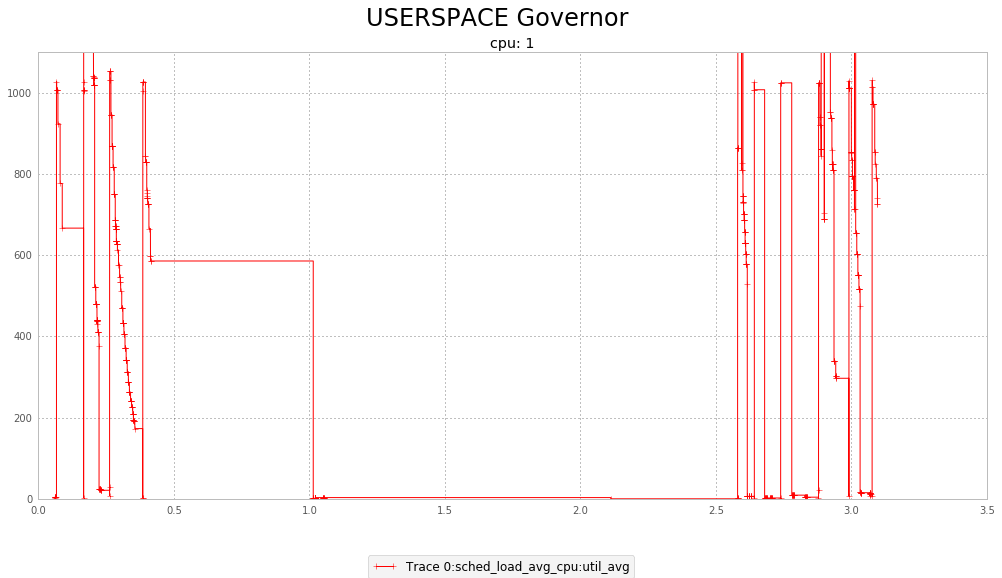

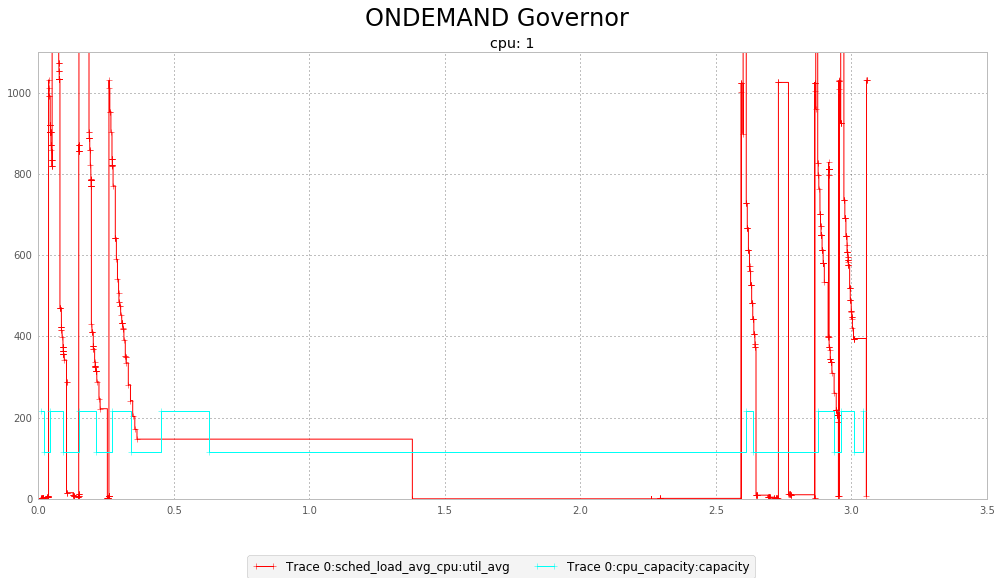

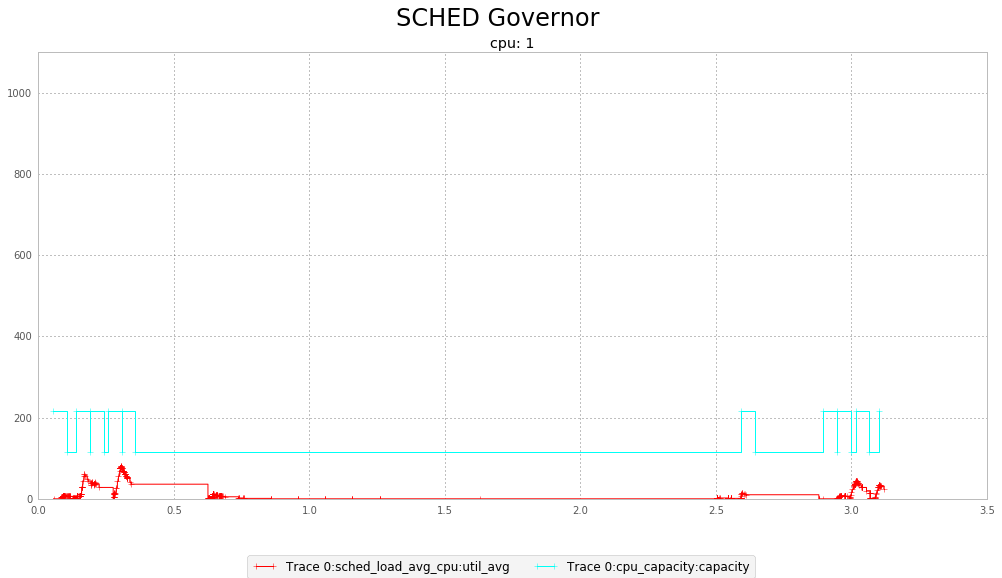

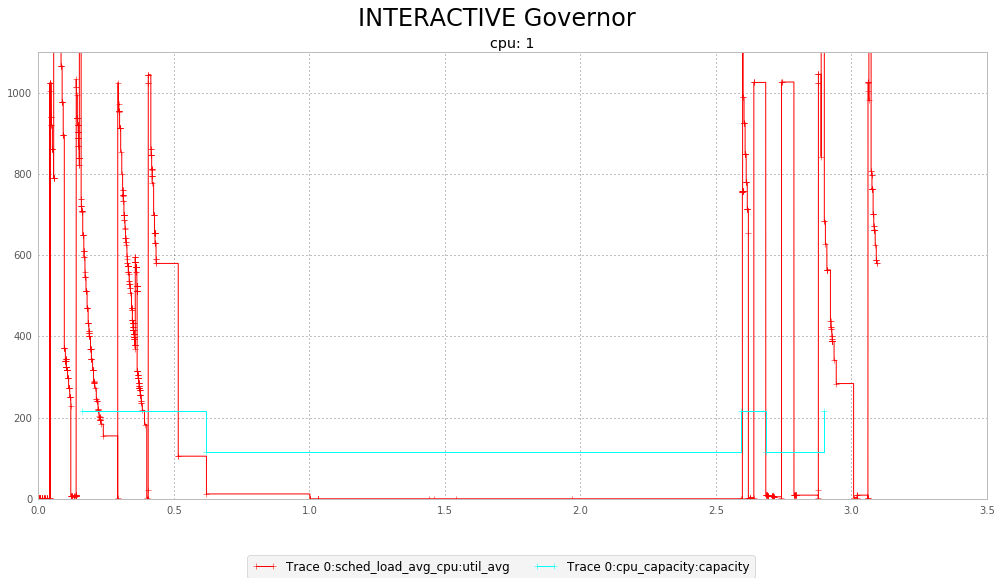

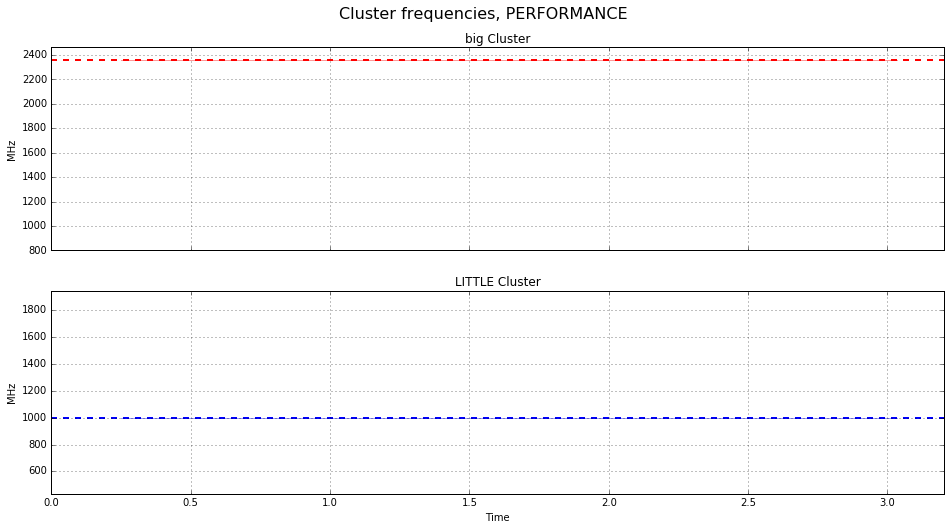

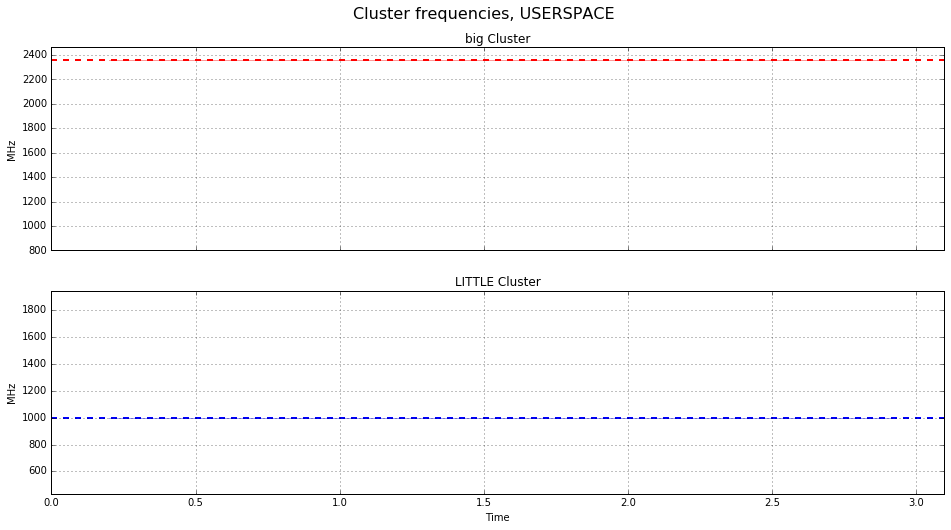

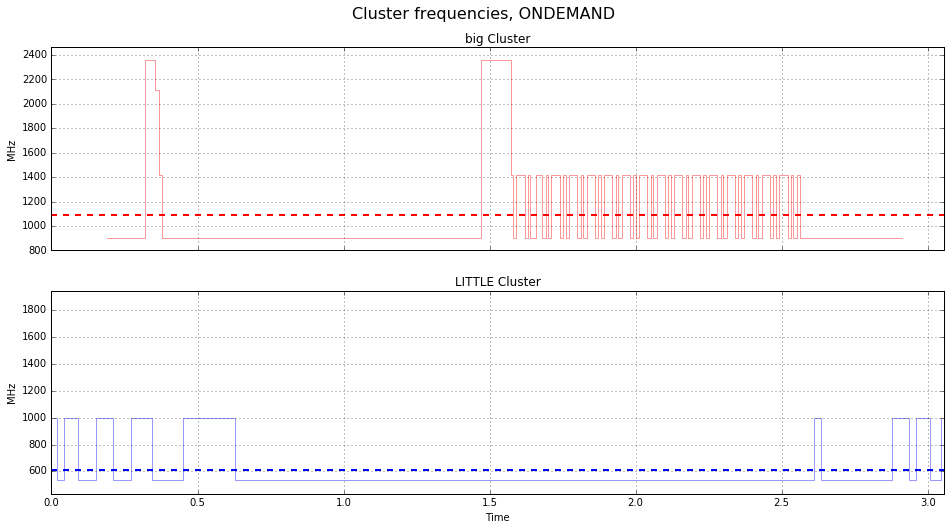

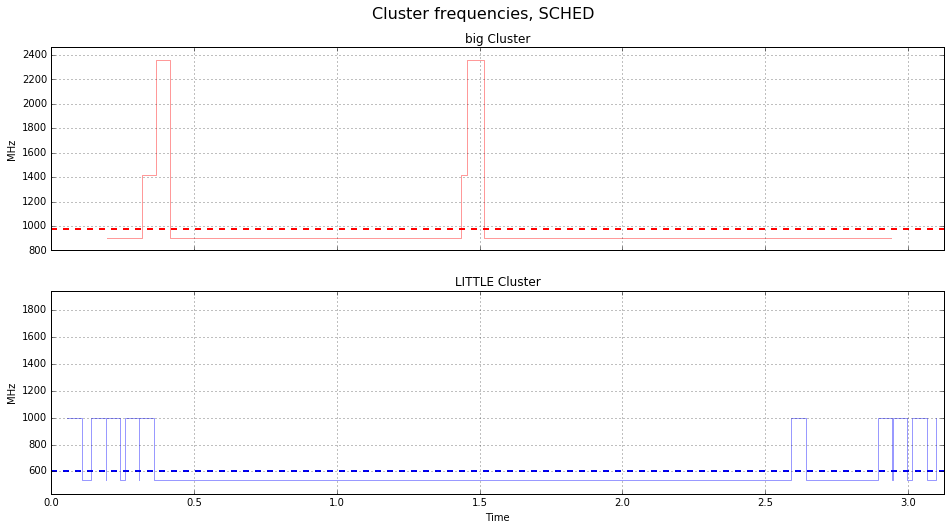

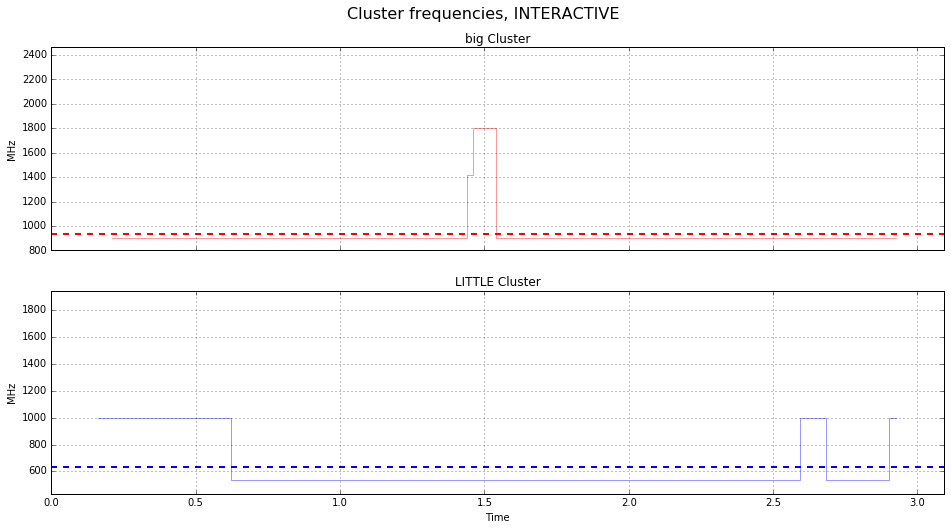

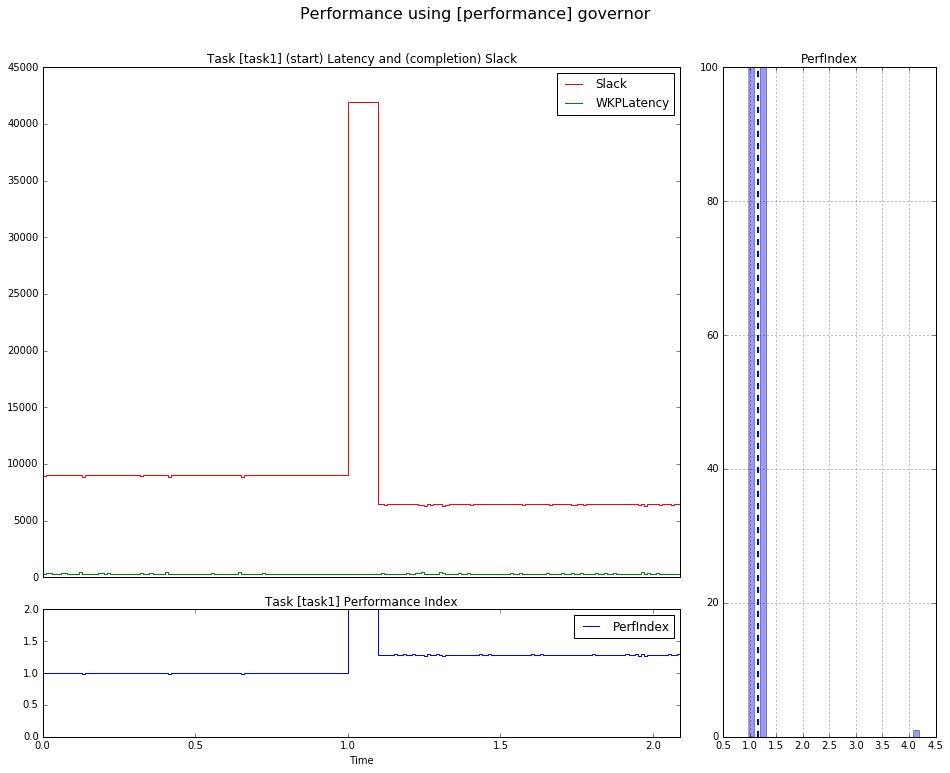

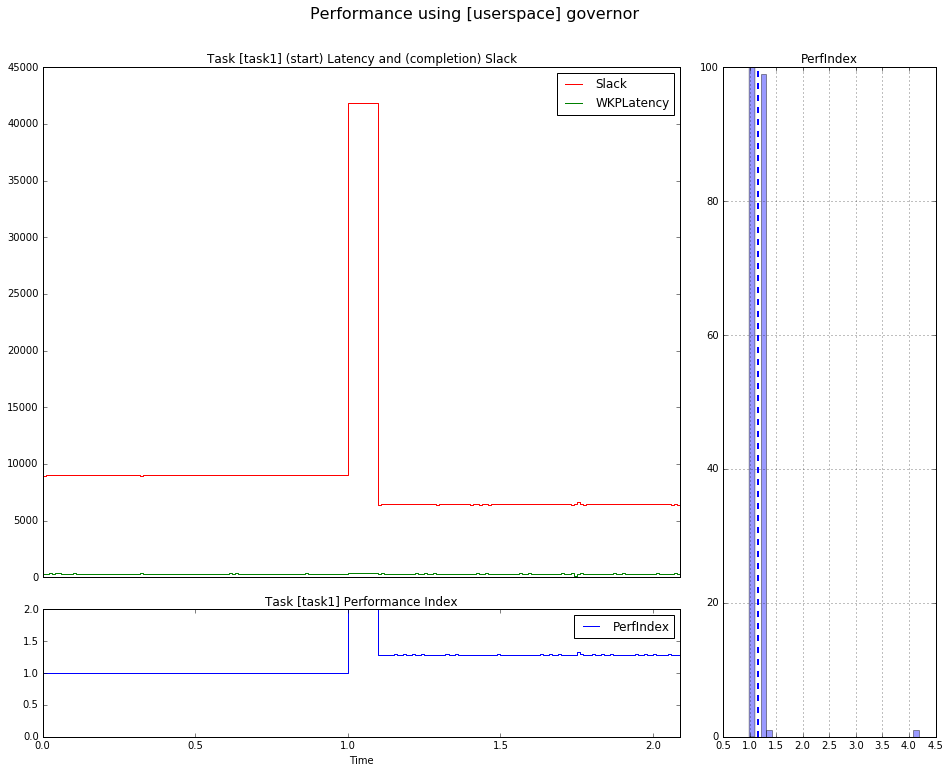

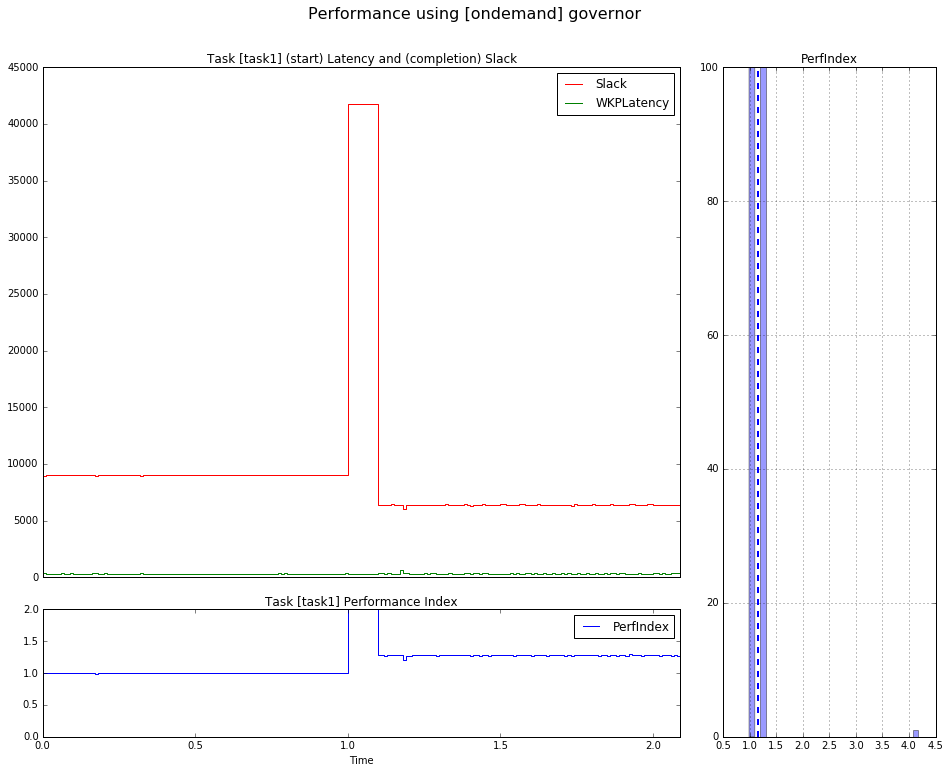

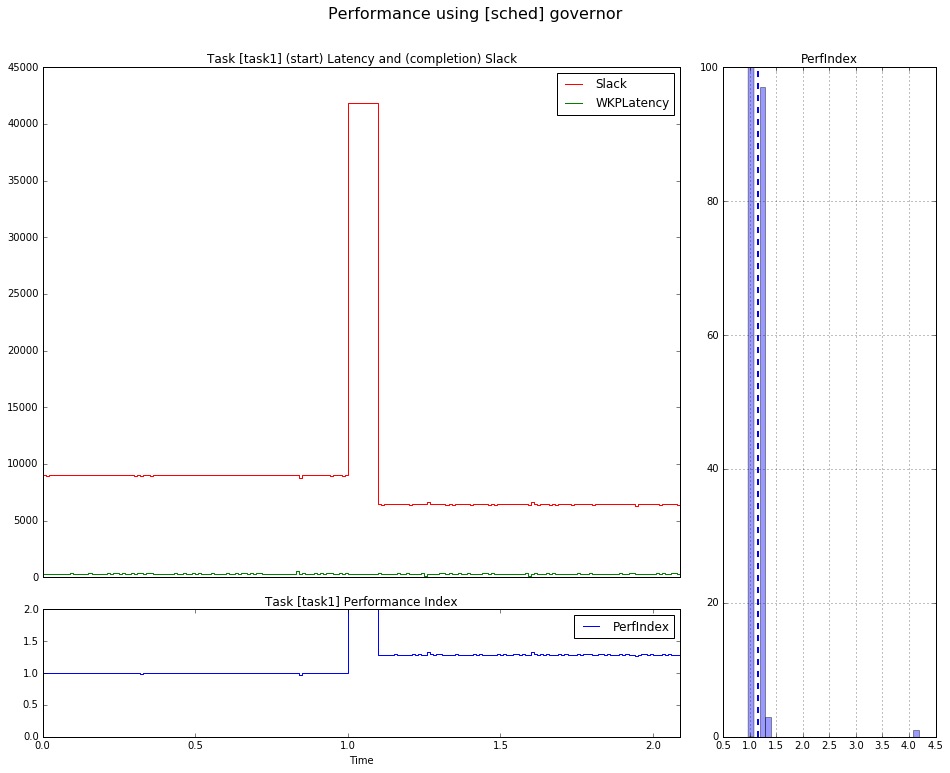

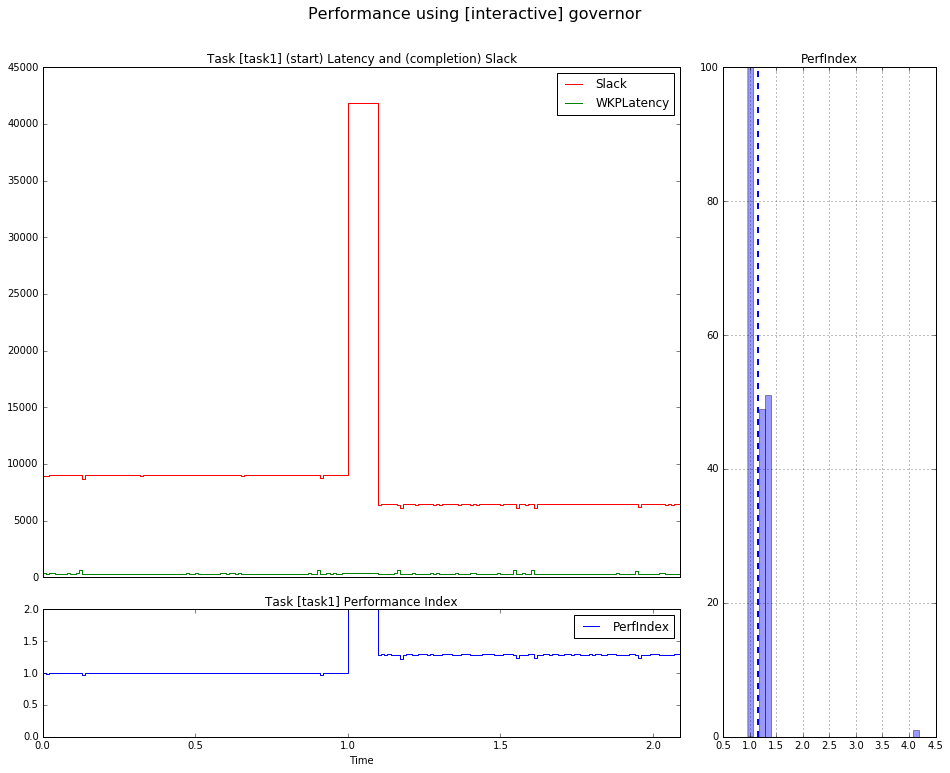

In [40]:
plot(test_case)

In [17]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.931     7.311     8.241
sched           |     0.544     5.823     6.368
powersave       |     0.534     4.575     5.108
ondemand        |     0.527     5.990     6.516
